In [14]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Design Intention Clarification (CAD Agent)

This notebook implements the **Design Intention Clarification** step of an
agentic CAD generation workflow, inspired by recent research on
human-in-the-loop CAD agents.

In CAD generation, users often provide **vague or underspecified requests**
(e.g., "Design an airplane"). While the high-level intent may be clear,
critical design details such as geometry, dimensions, structure, and style
are often missing.

Unlike research agents—where ambiguity can be tolerated—CAD agents require
**explicit and sufficient design intent** before proceeding to downstream
steps such as constraint parsing, geometry generation, or verification.


## Motivation from Research Literature

In the reference paper, the agentic workflow begins with a **design intention
clarification** step.

Example from the paper:
- User request: *"Write an airplane"*
- Problem: The request lacks critical details such as:
  - fuselage style
  - wingspan
  - tail configuration
  - dimensions and parameters

The agent detects this underspecification and initiates a **clarification loop**
with the user, asking targeted questions until sufficient information is
collected to proceed with CAD generation.

This notebook focuses **only** on implementing that clarification step.


## What Is Design Intent?

In this project, **design intent** refers to the minimum set of information
required to reasonably begin CAD model generation.

Design intent is **not**:
- A full CAD model
- Parsed constraints
- Verified manufacturability

Design intent **includes**:
- What object is being designed
- The functional purpose of the object
- High-level structural or stylistic choices
- Any explicitly stated dimensions or parameters
- Identification of missing but critical information


## Why Clarification Must Be Iterative

A single-pass extraction of intent is insufficient for CAD tasks.

Key reasons:
- Wrong assumptions lead to invalid geometry
- Missing dimensions block parametric modeling
- Structural choices (e.g., tail type) affect the entire design

Therefore, the agent must:
1. Analyze the current user input
2. Decide whether clarification is required
3. Ask targeted questions if needed
4. Update the internal design intent state
5. Repeat until intent is sufficient


In [15]:
from utils import show_prompt
from cad_agent_from_scratch.prompts import clarify_design_intent_instructions
show_prompt(clarify_design_intent_instructions, "Clarify Design Intent Instructions")

╭────────────────────────────────────── Clarify Design Intent Instructions ───────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages exchanged so far between the user and the CAD assistant:                                │
│                                                                                                                 │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Your task is to determine whether the current design request contains                                          │
│  SUFFICIENT information to BEGIN CAD model generation.                                                          │
│                                                                                                                 │
│  IMPORTANT:                                                                                                     │
│  Your goal is NOT to fully specify the design.                                                                  │
│  Your goal is to collect enough information to safely hand off to the next CAD agent.                           │
│                                                                                                                 │
│  A design intent is considered SUFFICIENT if:                                                                   │
│  - The object type is clear                                                                                     │
│  - The overall size is approximately defined                                                                    │
│  - The major configuration/style is defined                                                                     │
│  - The model is static or movable                                                                               │
│  - Major components are identified                                                                              │
│                                                                                                                 │
│  Do NOT attempt to refine:                                                                                      │
│  - Detailed proportions (e.g., chord length, airfoil shape)                                                     │
│  - Manufacturing tolerances                                                                                     │
│  - Secondary or cosmetic details                                                                                │
│                                                                                                                 │
│  --------------------------------------------------                                                             │
│  CLARIFICATION STRATEGY                                                                                         │
│  --------------------------------------------------                                                             │
│                                                                                                                 │
│  If clarification is required:                                                                                  │
│  - Ask MULTIPLE related questions in a SINGLE message.                                                          │
│  - Group questions logically.                         

### State and Schemas

First, we define the **state object** and **structured schemas** for the design intention clarification process.

The **state object** acts as the central mechanism for storing and passing context between different stages of the CAD agent workflow. As the agent interacts with the user through a clarification loop, the state is continuously updated to reflect the current understanding of the design intent.

This allows the agent to:

* Track the conversation history
* Maintain the evolving design intent
* Decide whether further clarification is required
* Pass a refined and sufficient intent to downstream CAD agents

We use structured schemas to ensure that decisions made by the agent—such as whether clarification is needed—are **deterministic, inspectable, and safe for downstream processing**. This is especially important in CAD workflows, where missing or incorrect assumptions can lead to invalid geometry or unusable models.

The state also enables **context engineering**, allowing the agent to selectively read from and write to specific parts of the context as the workflow progresses, rather than relying on unstructured prompt memory.

> **Note:** We will use `%%writefile` to save the state definitions and schemas into a dedicated file (e.g., `state_intent.py`). This makes the state reusable across future notebooks and ensures that the same definitions can later be used directly in a deployable LangGraph application.


In [16]:
%%writefile ../src/cad_agent_from_scratch/design_intent_state.py

"""State Definitions and Pydantic Schemas for CAD Design Intention Clarification.

This module defines the state objects and structured schemas used for
the design intention clarification step of an agentic CAD workflow.

The state manages conversation context, evolving design intent,
and parsed design parameters for downstream CAD agents.
"""

from typing_extensions import Optional, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field


# ===== STATE DEFINITIONS =====

class AgentInputState(MessagesState):
    """
    Input state for the CAD agent.

    This state contains only the messages provided by the user
    and serves as the entry point for the intention clarification workflow.
    """
    pass


class DesignIntentState(MessagesState):
    """
    Main state for the design intention clarification workflow.

    Extends MessagesState with additional fields required to:
    - Track evolving design intent
    - Decide whether further clarification is required
    - Store the finalized design intent
    - Store parsed design parameters for downstream agents
    """

    # Human-readable, refined design intent summary
    design_intent: Optional[str]

    # Structured representation of the design intent (output of parser node)
    parsed_intent: Optional[dict]

    # Whether the agent has determined that clarification is still required
    needs_clarification: bool = True

    # Messages exchanged during the clarification loop
    clarification_messages: Annotated[Sequence[BaseMessage], add_messages]


# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyDesignIntent(BaseModel):
    """
    Schema used by the CAD agent to determine whether the
    current design request requires further clarification.
    """

    need_clarification: bool = Field(
        description="Whether the current design intent is underspecified for CAD generation.",
    )

    question: str = Field(
        description="A concise clarification question to ask the user if clarification is required.",
    )

    summary: str = Field(
        description="A concise summary of the finalized design intent if sufficient information is available.",
    )

# ===== PARSER SCHEMA =====

class ParsedDesignIntent(BaseModel):
    """Structured representation of a clarified CAD design intent."""

    object_name: str = Field(
        description="Name of the object being designed (e.g., airplane, bracket, gear)."
    )

    components: Optional[list[str]] = Field(
        description="Major components explicitly mentioned by the user."
    )

    dimensions: Optional[dict[str, str]] = Field(
        description="Dimensions mentioned in the design intent with units preserved as text."
    )

    configuration: Optional[str] = Field(
        description="High-level configuration or style (e.g., T-tail, angular body)."
    )

    assumptions: Optional[list[str]] = Field(
        description="Explicit assumptions made due to missing information."
    )


Overwriting ../src/cad_agent_from_scratch/design_intent_state.py


### Design Intention Clarification Workflow

Now, we will create a simple **agentic workflow** to clarify the user’s CAD design intent through an interactive clarification loop.

The goal of this workflow is to determine whether the current design request contains **sufficient information to begin CAD model generation**, or whether additional clarification from the user is required.

Rather than hard-coding a fixed sequence of steps, we allow the **LLM to evaluate the current context** and decide:

* Whether clarification is still needed
* What the next clarification question should be
* When the design intent is sufficiently specified to proceed

This workflow uses LangGraph’s
[`Command`](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#combine-control-flow-and-state-updates-with-command)
to simultaneously control execution flow and update the agent state.

The `Command` object supports two key parameters:

* `goto`: Specifies the next node to execute (or `END` to terminate the workflow)
* `update`: A dictionary of state updates to apply before transitioning

This pattern allows each node to:

* Analyze the current design intent
* Update the evolving intent state
* Decide whether to continue the clarification loop or stop

By combining **control flow decisions** with **explicit state updates**, we create a workflow that is:

* Iterative rather than linear
* Human-in-the-loop by design
* Well-suited for handling underspecified CAD requests

This approach results in a more flexible and maintainable CAD agent compared to rigid, static graph structures, and directly supports the clarification behavior described in the reference agentic CAD workflow.


In [38]:
%%writefile ../src/cad_agent_from_scratch/design_intent_workflow.py




from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from cad_agent_from_scratch.design_intent_state import (
    DesignIntentState,
    AgentInputState,
    ClarifyDesignIntent,
    ParsedDesignIntent,
)

from cad_agent_from_scratch.prompts import (
    clarify_design_intent_instructions,
    PARSE_DESIGN_INTENT_PROMPT,
)

# ===== MODEL =====

model = init_chat_model(
    model="gpt-4o-mini",
    temperature=0.0,
)

# ===== PROMPT TEMPLATES =====

clarify_prompt = PromptTemplate(
    template=clarify_design_intent_instructions,
    input_variables=["messages"],
)

parse_prompt = PromptTemplate(
    template=PARSE_DESIGN_INTENT_PROMPT,
    input_variables=["design_intent"],
)

# ===== WORKFLOW NODES =====

def clarify_design_intent(
    state: DesignIntentState,
) -> Command[Literal["parse_design_intent", "__end__"]]:

    structured_model = model.with_structured_output(ClarifyDesignIntent)

    response = structured_model.invoke([
        HumanMessage(
            content=clarify_prompt.format(
                messages=get_buffer_string(state["messages"])
            )
        )
    ])

    if response.need_clarification:
        return Command(
            goto=END,
            update={
                "needs_clarification": True,
                "messages": [AIMessage(content=response.question)],
            },
        )

    return Command(
        goto="parse_design_intent",
        update={
            "needs_clarification": False,
            "design_intent": response.summary,
            "messages": [AIMessage(content=response.summary)],
        },
    )


def parse_design_intent(state: DesignIntentState):
    structured_parser = model.with_structured_output(ParsedDesignIntent)

    parsed = structured_parser.invoke([
        HumanMessage(
            content=parse_prompt.format(
                design_intent=state["design_intent"]
            )
        )
    ])

    return {
        "parsed_intent": parsed.model_dump()
    }

# ===== GRAPH =====

builder = StateGraph(
    DesignIntentState,
    input_schema=AgentInputState,
)

builder.add_node("clarify_design_intent", clarify_design_intent)
builder.add_node("parse_design_intent", parse_design_intent)

builder.add_edge(START, "clarify_design_intent")
builder.add_edge("parse_design_intent", END)

design_intent_workflow = builder.compile()

Overwriting ../src/cad_agent_from_scratch/design_intent_workflow.py


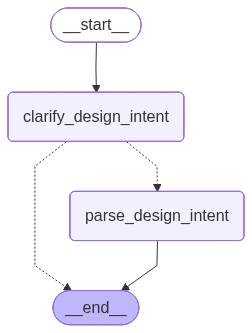

In [28]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

from cad_agent_from_scratch.design_intent_workflow import builder

checkpointer = InMemorySaver()

scope = builder.compile(checkpointer=checkpointer)

display(Image(scope.get_graph(xray=True).draw_mermaid_png()))


In [29]:
# Run the CAD design intention workflow
from utils import format_messages
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke(
    {"messages": [HumanMessage(content="Design a small airplane for educational demonstration purposes")]},
    config=thread)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a small airplane for educational demonstration purposes                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you provide more details about the airplane's size (e.g., wingspan or length), its major components       │
│ (e.g., wings, tail, fuselage), and whether it should be a static model or have movable parts?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [30]:
result = scope.invoke(
    {
        "messages": [
            HumanMessage(
                content="The airplane should be a simple propeller-driven configuration with a wingspan of about 120 units and a fuselage length of around 100 units. It should be a static model with no movable parts such as flaps or ailerons."
            )
        ]
    },
    config=thread
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a small airplane for educational demonstration purposes                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you provide more details about the airplane's size (e.g., wingspan or length), its major components       │
│ (e.g., wings, tail, fuselage), and whether it should be a static model or have movable parts?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simple propeller-driven configuration with a wingspan of about 120 units and a         │
│ fuselage length of around 100 units. It should be a static model with no movable parts such as flaps or         │
│ ailerons.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a small static propeller-driven airplane with a wingspan of about 120 units and a fuselage length of     │
│ around 100 units.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [31]:
result = scope.invoke(
    {
        "messages": [
            HumanMessage(
                content="The airplane should use a simple propeller-based propulsion system suitable for an educational, static demonstration model."
            )
        ]
    },
    config=thread
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a small airplane for educational demonstration purposes                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you provide more details about the airplane's size (e.g., wingspan or length), its major components       │
│ (e.g., wings, tail, fuselage), and whether it should be a static model or have movable parts?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simple propeller-driven configuration with a wingspan of about 120 units and a         │
│ fuselage length of around 100 units. It should be a static model with no movable parts such as flaps or         │
│ ailerons.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a small static propeller-driven airplane with a wingspan of about 120 units and a fuselage length of     │
│ around 100 units.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should use a simple propeller-based propulsion system suitable for an educational, static          │
│ demonstration model.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the type of materials you envision for the airplane's construction (e.g., wood, plastic,      │
│ foam)? Also, do you have any preferences for the design style (e.g., modern, vintage) or any specific color     │
│ scheme?                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [32]:
result = scope.invoke(
    {
        "messages": [
            HumanMessage(
                content="Use a generic lightweight material assumption, such as plastic or aluminum, suitable for an educational static model. Exact material properties are not critical."
            )
        ]
    },
    config=thread
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a small airplane for educational demonstration purposes                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you provide more details about the airplane's size (e.g., wingspan or length), its major components       │
│ (e.g., wings, tail, fuselage), and whether it should be a static model or have movable parts?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simple propeller-driven configuration with a wingspan of about 120 units and a         │
│ fuselage length of around 100 units. It should be a static model with no movable parts such as flaps or         │
│ ailerons.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a small static propeller-driven airplane with a wingspan of about 120 units and a fuselage length of     │
│ around 100 units.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should use a simple propeller-based propulsion system suitable for an educational, static          │
│ demonstration model.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the type of materials you envision for the airplane's construction (e.g., wood, plastic,      │
│ foam)? Also, do you have any preferences for the design style (e.g., modern, vintage) or any specific color     │
│ scheme?                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use a generic lightweight material assumption, such as plastic or aluminum, suitable for an educational static  │
│ model. Exact material properties are not critical.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [33]:
result = scope.invoke(
    {
        "messages": [
            HumanMessage(
                content="The airplane should be a simplified external model only, without detailed internal components such as a cockpit or control mechanisms."
            )
        ]
    },
    config=thread
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a small airplane for educational demonstration purposes                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you provide more details about the airplane's size (e.g., wingspan or length), its major components       │
│ (e.g., wings, tail, fuselage), and whether it should be a static model or have movable parts?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simple propeller-driven configuration with a wingspan of about 120 units and a         │
│ fuselage length of around 100 units. It should be a static model with no movable parts such as flaps or         │
│ ailerons.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a small static propeller-driven airplane with a wingspan of about 120 units and a fuselage length of     │
│ around 100 units.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should use a simple propeller-based propulsion system suitable for an educational, static          │
│ demonstration model.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the type of materials you envision for the airplane's construction (e.g., wood, plastic,      │
│ foam)? Also, do you have any preferences for the design style (e.g., modern, vintage) or any specific color     │
│ scheme?                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use a generic lightweight material assumption, such as plastic or aluminum, suitable for an educational static  │
│ model. Exact material properties are not critical.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simplified external model only, without detailed internal components such as a cockpit │
│ or control mechanisms.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [34]:
result = scope.invoke(
    {
        "messages": [
            HumanMessage(
                content="Use a simple high-wing monoplane configuration, similar to a basic training aircraft.The approximate height of the airplane should be around 35 units from the bottom of the landing gear to the top of the tail. Exact precision is not critical."
            )
        ]
    },
    config=thread
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a small airplane for educational demonstration purposes                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you provide more details about the airplane's size (e.g., wingspan or length), its major components       │
│ (e.g., wings, tail, fuselage), and whether it should be a static model or have movable parts?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simple propeller-driven configuration with a wingspan of about 120 units and a         │
│ fuselage length of around 100 units. It should be a static model with no movable parts such as flaps or         │
│ ailerons.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a small static propeller-driven airplane with a wingspan of about 120 units and a fuselage length of     │
│ around 100 units.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should use a simple propeller-based propulsion system suitable for an educational, static          │
│ demonstration model.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the type of materials you envision for the airplane's construction (e.g., wood, plastic,      │
│ foam)? Also, do you have any preferences for the design style (e.g., modern, vintage) or any specific color     │
│ scheme?                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use a generic lightweight material assumption, such as plastic or aluminum, suitable for an educational static  │
│ model. Exact material properties are not critical.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simplified external model only, without detailed internal components such as a cockpit │
│ or control mechanisms.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use a simple high-wing monoplane configuration, similar to a basic training aircraft.The approximate height of  │
│ the airplane should be around 35 units from the bottom of the landing gear to the top of the tail. Exact        │
│ precision is not critical.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
result = scope.invoke(
    {
        "messages": [
            HumanMessage(
                content="Yes, include simple fixed landing gear with two main wheels and a small tail wheel. No retractable or detailed suspension is required."
            )
        ]
    },
    config=thread
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a small airplane for educational demonstration purposes                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you provide more details about the airplane's size (e.g., wingspan or length), its major components       │
│ (e.g., wings, tail, fuselage), and whether it should be a static model or have movable parts?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simple propeller-driven configuration with a wingspan of about 120 units and a         │
│ fuselage length of around 100 units. It should be a static model with no movable parts such as flaps or         │
│ ailerons.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a small static propeller-driven airplane with a wingspan of about 120 units and a fuselage length of     │
│ around 100 units.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should use a simple propeller-based propulsion system suitable for an educational, static          │
│ demonstration model.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the type of materials you envision for the airplane's construction (e.g., wood, plastic,      │
│ foam)? Also, do you have any preferences for the design style (e.g., modern, vintage) or any specific color     │
│ scheme?                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use a generic lightweight material assumption, such as plastic or aluminum, suitable for an educational static  │
│ model. Exact material properties are not critical.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simplified external model only, without detailed internal components such as a cockpit │
│ or control mechanisms.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use a simple high-wing monoplane configuration, similar to a basic training aircraft.The approximate height of  │
│ the airplane should be around 35 units from the bottom of the landing gear to the top of the tail. Exact        │
│ precision is not critical.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes, include simple fixed landing gear with two main wheels and a small tail wheel. No retractable or detailed  │
│ suspension is required.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [36]:
result = scope.invoke(
    {
        "messages": [
            HumanMessage(
                content="A modern, minimal design is preferred. Use a basic white-and-blue color scheme; exact shades can be adjusted later."
            )
        ]
    },
    config=thread
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Design a small airplane for educational demonstration purposes                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you provide more details about the airplane's size (e.g., wingspan or length), its major components       │
│ (e.g., wings, tail, fuselage), and whether it should be a static model or have movable parts?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simple propeller-driven configuration with a wingspan of about 120 units and a         │
│ fuselage length of around 100 units. It should be a static model with no movable parts such as flaps or         │
│ ailerons.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a small static propeller-driven airplane with a wingspan of about 120 units and a fuselage length of     │
│ around 100 units.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should use a simple propeller-based propulsion system suitable for an educational, static          │
│ demonstration model.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the type of materials you envision for the airplane's construction (e.g., wood, plastic,      │
│ foam)? Also, do you have any preferences for the design style (e.g., modern, vintage) or any specific color     │
│ scheme?                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use a generic lightweight material assumption, such as plastic or aluminum, suitable for an educational static  │
│ model. Exact material properties are not critical.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The airplane should be a simplified external model only, without detailed internal components such as a cockpit │
│ or control mechanisms.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use a simple high-wing monoplane configuration, similar to a basic training aircraft.The approximate height of  │
│ the airplane should be around 35 units from the bottom of the landing gear to the top of the tail. Exact        │
│ precision is not critical.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes, include simple fixed landing gear with two main wheels and a small tail wheel. No retractable or detailed  │
│ suspension is required.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify the design style (e.g., modern, vintage) and any specific color scheme you have in mind for   │
│ the airplane?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ A modern, minimal design is preferred. Use a basic white-and-blue color scheme; exact shades can be adjusted    │
│ later.                                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Design a small static propeller-driven airplane with a wingspan of about 120 units, a fuselage length of around │
│ 100 units, a height of approximately 35 units, a high-wing monoplane configuration, simple fixed landing gear   │
│ with two main wheels and a small tail wheel, a modern minimal design style, and a basic white-and-blue color    │
│ scheme.                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

We can inspect the execution of the design intention workflow using **LangSmith traces**, which provide visibility into each LangGraph node execution, state updates, and LLM calls.

https://smith.langchain.com/public/54d26507-dd2a-4c9f-9f1a-ddcc8db1749b/r

---

## Local Deployment and LangGraph Studio (CAD Agent)

LangGraph is designed to seamlessly support **local and production deployment** of agentic workflows.

The files generated using `%%writefile` during this notebook form the **core CAD Agent application**, specifically implementing **Step-1: Design Intention Clarification and Parsing**.

The resulting project structure looks like this:

```
cad_agent_from_scratch/
├── src/cad_agent_from_scratch/
│   ├── design_intent_state.py    # State & schemas for CAD intent
│   ├── design_intent_workflow.py    # Intention clarification + parsing workflow
│   ├── prompts.py                # CAD-specific prompt templates
│   └── ...
├── notebooks/                    # Development notebooks (source of truth)
├── pyproject.toml                # Dependencies and environment setup
└── langgraph.json                # LangGraph configuration
```

### What this enables

* The **notebooks** are used for iterative development and experimentation
* The **`src/` directory** contains deployable LangGraph workflows
* The **design intention workflow** can be:

  * Tested locally
  * Run as a service
  * Extended with downstream CAD agents (constraint parsing, geometry planning, code generation)

---

## LangGraph Configuration

The repository includes a `langgraph.json` file that specifies:

* Which graphs are exposed
* Required dependencies
* Environment variables (e.g., API keys)
* Entry points for LangGraph Studio and servers

This setup allows the **CAD design intention workflow** to be deployed:

* Locally for debugging
* As a backend service for a CAD UI
* As part of a larger multi-agent CAD system


---

## Running LangGraph Studio Locally

From the **root of the CAD Agent repository**, you can start a local LangGraph server and open **LangGraph Studio** in your browser using:

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev
```

This will:

* Launch a local LangGraph server
* Load your **design intention workflow**
* Allow you to:

  * Visualize the graph
  * Inspect state transitions
  * Replay runs
  * Debug parsing and clarification behavior interactively

---


# Evaluation

Now that we’ve completed **Design Intention Clarification and Parsing**, we can test the workflow with a few example conversations to verify that it behaves as expected.

In a CAD context, a **good clarified and parsed design intent** should satisfy the following:

* It accurately captures **all explicitly stated design decisions** from the user conversation
* It does **not invent geometry, dimensions, components, or configurations**
* It clearly distinguishes between:

  * Explicitly provided information
  * Assumptions (only when unavoidable)
* It produces a **structured output** that can be safely consumed by downstream CAD agents (e.g., constraint parsing, geometry planning)

Below are a few sample input conversations used to evaluate whether the design intention workflow:

1. Asks clarification questions when required
2. Stops clarifying once sufficient information is provided
3. Produces a clean, structured `parsed_intent` without hallucination


In [39]:
from langchain_core.messages import HumanMessage, AIMessage

conversation_1 = [
    HumanMessage(content="Design a small airplane."),
    AIMessage(content="What is the approximate wingspan or size of the airplane?"),
    HumanMessage(content="Around 120 units wingspan and 100 units length."),
    AIMessage(content="Should it be static or have movable parts?"),
    HumanMessage(content="Static model only."),
]

conversation_2 = [
    HumanMessage(content="Create an airplane CAD model."),
    AIMessage(content="What type of airplane should it represent?"),
    HumanMessage(content="A simple propeller-driven monoplane."),
    AIMessage(content="Any specific dimensions?"),
    HumanMessage(content="Wingspan 120 units, fuselage length 100 units."),
]


In [40]:
criteria_1 = [
    "Object is an airplane",
    "Wingspan is approximately 120 units",
    "Fuselage length is approximately 100 units",
    "Model is static (no movable parts)",
]

criteria_2 = [
    "Object is an airplane",
    "Configuration is propeller-driven monoplane",
    "Wingspan is approximately 120 units",
    "Fuselage length is approximately 100 units",
]


In [41]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

dataset_name = "cad_design_intent_evaluation"

if not langsmith_client.has_dataset(dataset_name=dataset_name):
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="Evaluation dataset for CAD design intent clarification and parsing",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"messages": conversation_1},
                "outputs": {"criteria": criteria_1},
            },
            {
                "inputs": {"messages": conversation_2},
                "outputs": {"criteria": criteria_2},
            },
        ],
    )

datasets = list(langsmith_client.list_datasets())
ds = next(d for d in datasets if d.name == dataset_name)
print("Dataset object:", ds)


Dataset object: name='cad_design_intent_evaluation' description='Evaluation dataset for CAD design intent clarification and parsing' data_type=<DataType.kv: 'kv'> id=UUID('61cecbc0-44f3-4be0-8172-21bdf4f16853') created_at=datetime.datetime(2025, 12, 17, 11, 53, 33, 468234, tzinfo=datetime.timezone.utc) modified_at=datetime.datetime(2025, 12, 17, 11, 53, 33, 468234, tzinfo=datetime.timezone.utc) example_count=2 session_count=0 last_session_start_time=None inputs_schema=None outputs_schema=None transformations=None metadata={'runtime': {'sdk': 'langsmith-py', 'library': 'langsmith', 'runtime': 'python', 'platform': 'Windows-10-10.0.26200-SP0', 'sdk_version': '0.5.0', 'runtime_version': '3.11.9', 'langchain_version': '1.2.0', 'py_implementation': 'CPython', 'langchain_core_version': '1.2.2'}}


In [42]:
from cad_agent_from_scratch.prompts import CAD_CRITERIA_PROMPT
show_prompt(CAD_CRITERIA_PROMPT, "CAD_CRITERIA_PROMPT")

╭────────────────────────────────────────────── CAD_CRITERIA_PROMPT ──────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are a CAD design intent evaluator.                                                                         │
│                                                                                                                 │
│  Your task is to determine whether the parsed CAD design intent                                                 │
│  captures the specific design criterion provided.                                                               │
│                                                                                                                 │
│  Criterion:                                                                                                     │
│  {criterion}                                                                                                    │
│                                                                                                                 │
│  Parsed Design Intent:                                                                                          │
│  {parsed_intent}                                                                                                │
│                                                                                                                 │
│  Judgment rules:                                                                                                │
│  - CAPTURED if the criterion is explicitly present or clearly implied                                           │
│  - NOT CAPTURED if missing, vague, or contradicted                                                              │
│  - Do NOT infer dimensions or components that are not present                                                   │
│                                                                                                                 │
│  Respond in structured form.                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [46]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

class CADCriteriaEval(BaseModel):
    criteria_text: str
    reasoning: str
    is_captured: bool

def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
    parsed_intent = outputs["parsed_intent"]
    success_criteria = reference_outputs["criteria"]

    model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    structured_model = model.with_structured_output(CADCriteriaEval)

    responses = structured_model.batch([
        [
            HumanMessage(
                content=CAD_CRITERIA_PROMPT.format(
                    criterion=criterion,
                    parsed_intent=str(parsed_intent),
                )
            )
        ]
        for criterion in success_criteria
    ])

    evaluations = [
        CADCriteriaEval(
            criteria_text=criterion,
            reasoning=response.reasoning,
            is_captured=response.is_captured,
        )
        for criterion, response in zip(success_criteria, responses)
    ]

    captured = sum(1 for e in evaluations if e.is_captured)

    return {
        "key": "cad_success_criteria_score",
        "score": captured / len(evaluations),
        "individual_evaluations": [
            {
                "criteria": e.criteria_text,
                "captured": e.is_captured,
                "reasoning": e.reasoning,
            }
            for e in evaluations
        ],
    }


In [47]:
from cad_agent_from_scratch.prompts import CAD_HALLUCINATION_PROMPT
show_prompt(CAD_HALLUCINATION_PROMPT, "CAD_HALLUCINATION_PROMPT")

╭─────────────────────────────────────────── CAD_HALLUCINATION_PROMPT ────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are a CAD design auditor.                                                                                  │
│                                                                                                                 │
│  Check whether the parsed design intent introduces                                                              │
│  any geometry, dimensions, components, or configurations                                                        │
│  that were NOT explicitly stated by the user.                                                                   │
│                                                                                                                 │
│  Parsed Design Intent:                                                                                          │
│  {parsed_intent}                                                                                                │
│                                                                                                                 │
│  User Criteria:                                                                                                 │
│  {success_criteria}                                                                                             │
│                                                                                                                 │
│  PASS if no extra assumptions exist.                                                                            │
│  FAIL if any unstated features are introduced.                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [48]:
class NoCADAssumptions(BaseModel):
    no_assumptions: bool
    reasoning: str

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    parsed_intent = outputs["parsed_intent"]
    success_criteria = reference_outputs["criteria"]

    model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    structured_model = model.with_structured_output(NoCADAssumptions)

    response = structured_model.invoke([
        HumanMessage(
            content=CAD_HALLUCINATION_PROMPT.format(
                parsed_intent=str(parsed_intent),
                success_criteria=str(success_criteria),
            )
        )
    ])

    return {
        "key": "cad_no_assumptions_score",
        "score": response.no_assumptions,
        "reasoning": response.reasoning,
    }

In [50]:
import uuid

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state = scope.invoke(inputs, config=config)

    # Explicitly expose parsed_intent for evaluators
    return {
        "parsed_intent": state.get("parsed_intent"),
        "design_intent": state.get("design_intent"),
        "messages": state.get("messages"),
    }


langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_success_criteria, evaluate_no_assumptions],
    experiment_prefix="CAD Design Intent Evaluation",
)

View the evaluation results for experiment: 'CAD Design Intent Evaluation-2a17e4c8' at:
https://smith.langchain.com/o/7aa3a156-5909-41ad-a7a3-8ec0e834b081/datasets/61cecbc0-44f3-4be0-8172-21bdf4f16853/compare?selectedSessions=56dab55a-45ed-47e3-9655-dbd415e5c8da




0it [00:00, ?it/s]

<ExperimentResults CAD Design Intent Evaluation-2a17e4c8>